In [1]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi

from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile
from glob import glob
# used chatgpt to help me generate some functions

C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from typing import List
from glob import glob
from miditoolkit import MidiFile, Instrument, Note
import math

In [39]:
# Data Preparation
midi_files = glob('nes_midis/*.mid')
np.random.seed(42)
np.random.shuffle(midi_files)

generation_file = midi_files[0]
train_files = midi_files[1:]

# Tokenizer
class PitchTokenizer:
    def __call__(self, midi_obj: pretty_midi.PrettyMIDI):
        notes = []
        if not midi_obj.instruments:
            return notes
        for note in midi_obj.instruments[0].notes:
            notes.append(note.pitch)
        return notes

    def decode(self, tokens: List[int]) -> pretty_midi.PrettyMIDI:
        midi_out = pretty_midi.PrettyMIDI()
        inst = pretty_midi.Instrument(program=0, is_drum=False, name="piano")
        time = 0
        duration = 0.5  # seconds
        for pitch in tokens:
            note = pretty_midi.Note(velocity=80, pitch=pitch, start=time, end=time + duration)
            inst.notes.append(note)
            time += duration
        midi_out.instruments.append(inst)
        return midi_out

tokenizer = PitchTokenizer()

# Dataset
class MIDIDataset(Dataset):
    def __init__(self, file_paths: List[str], tokenizer):
        self.tokenizer = tokenizer
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        midi = MidiFile(self.file_paths[idx])
        tokens = self.tokenizer(midi)
        return torch.tensor(tokens, dtype=torch.int32)

train_dataset = MIDIDataset(train_files, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Second-order Markov Chain
class SecondOrderMarkovChain:
    def __init__(self):
        self.transitions = defaultdict(lambda: defaultdict(int))
        self.probabilities = defaultdict(lambda: defaultdict(float))
        self.losses = []
        self.perplexities = []

    def train(self, loader):
        for sequence_batch in loader:
            sequence = sequence_batch.squeeze(0).tolist()
            for i in range(len(sequence) - 2):
                s1, s2, s3 = sequence[i], sequence[i + 1], sequence[i + 2]
                self.transitions[(s1, s2)][s3] += 1
                
            cross_entropy_sum = 0.0
            count = 0
            for i in range(len(sequence) - 2):
                s1, s2, s3 = sequence[i], sequence[i + 1], sequence[i + 2]
                total = sum(self.transitions[(s1, s2)].values())
                prob = self.transitions[(s1, s2)][s3] / total
                cross_entropy_sum += -math.log(prob + 1e-8)
                count += 1
            if count > 0:
                avg_loss = cross_entropy_sum / count
                self.losses.append(avg_loss)
                self.perplexities.append(math.exp(avg_loss))
    
        for (s1, s2), next_states in self.transitions.items():
            total = sum(next_states.values())
            for s3, count in next_states.items():
                self.probabilities[(s1, s2)][s3] = count / total

    def generate(self, seed_sequence, num_predictions=100):
        seed = seed_sequence.squeeze(0).tolist()
        results = [seed[0], seed[1]]
        for _ in range(num_predictions):
            key = (results[-2], results[-1])
            if key not in self.probabilities:
                break
            next_states = list(self.probabilities[key].keys())
            probs = list(self.probabilities[key].values())
            next_token = np.random.choice(next_states, p=probs)
            results.append(next_token)
        return results

In [40]:
model = SecondOrderMarkovChain()
model.train(train_loader)

In [41]:
gen_sequence = tokenizer(MidiFile(generation_file))
generated_tokens = model.generate(torch.tensor(gen_sequence).unsqueeze(0), num_predictions=100)

# Save MIDI
midi_out = tokenizer.decode(generated_tokens)
midi_out.write("generated.mid")

In [42]:
midi = miditoolkit.MidiFile("generated.mid")
print(f"Ticks per beat: {midi.ticks_per_beat}")
print(f"Tempo changes: {len(midi.tempo_changes)}")
print(f"Number of tracks: {len(midi.instruments)}")

total_notes = 0
for i, track in enumerate(midi.instruments):
    num_notes = len(track.notes)
    total_notes += num_notes
    print(f"Track {i}: {num_notes} notes, program {track.program}")
    
    if num_notes > 0:
        pitches = [note.pitch for note in track.notes]
        velocities = [note.velocity for note in track.notes]
        avg_velocity = sum(velocities) / len(velocities)
        print(f"  Pitch range: {min(pitches)}-{max(pitches)}")
        print(f"  Average volume: {avg_velocity:.1f}/127")
        print(f"  First note: pitch {track.notes[0].pitch}, start {track.notes[0].start}")

print(f"Total notes: {total_notes}")

Ticks per beat: 220
Tempo changes: 1
Number of tracks: 1
Track 0: 102 notes, program 0
  Pitch range: 0-93
  Average volume: 80.0/127
  First note: pitch 35, start 0
Total notes: 102


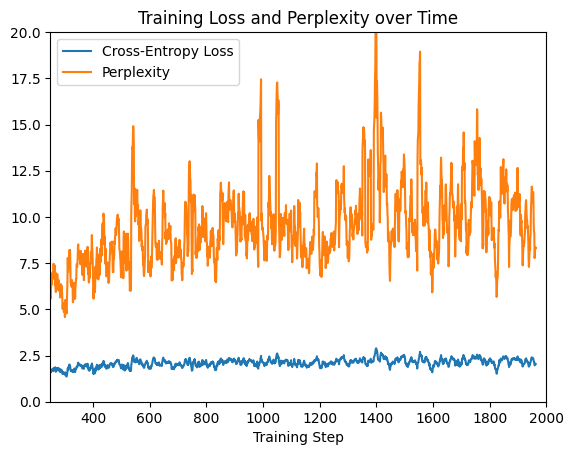

In [44]:
import matplotlib.pyplot as plt
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

steps = list(range(1, len(model.losses) + 1))

smoothed_loss = moving_average(model.losses, window_size=10)
smoothed_perplexity = moving_average(model.perplexities, window_size=10)
smoothed_steps = list(range(1, len(smoothed_loss) + 1))

plt.plot(smoothed_steps, smoothed_loss, label="Cross-Entropy Loss")
plt.plot(smoothed_steps, smoothed_perplexity, label="Perplexity")
plt.xlabel("Training Step")
plt.title("Training Loss and Perplexity over Time")
plt.xlim(250, 2000)
plt.ylim(0, 20)
plt.legend()
plt.show()